# LMDB数据格式

## LMDB格式介绍
LMDB 全称为 Lightning Memory-Mapped Database，就是非常快的内存映射型数据库，LMDB使用内存映射文件，可以提供更好的输入/输出性能，LMDB属于key-value数据库，LMDB提供 key-value分布式存储，其中每个键值对都是我们数据集中的一个样本。<br/>
key是关键字，value是值，主要特点是并发读写性能。

In [3]:
#将图片数据以及label的地址索引写入csv格式文件中
import os
import random

image_list = []
label_list = []

rootdir = '/Users/zhaomingming/Downloads/week6课上代码以及上节课作业/作业-week5/作业/lane_segmentation/small_dataset'
#rootdir='作业-week5/作业/lane_segmentation/small_dataset'
#image_dirs = ['D:\kkb\cartrace\home-week5\small_dataset\Road%02d' % i for i in range(2, 5)]
#label_dir = 'D:\kkb\cartrace\home-week5\small_dataset\Gray_Label'
image_dirs = ['/Users/zhaomingming/Downloads/week6课上代码以及上节课作业/作业-week5/作业/lane_segmentation/small_dataset/Road%02d' % i for i in range(2, 5)]
label_dir = '/Users/zhaomingming/Downloads/week6课上代码以及上节课作业/作业-week5/作业/lane_segmentation/small_dataset/Gray_Label'



for image_dir in image_dirs:
    road_idx = int(image_dir[-1])
    image_root = os.path.join(image_dir, 'ColorImage_road%02d/ColorImage' % road_idx)
    label_root = os.path.join(label_dir, 'Label_road%02d/Label' % road_idx)
    #print(label_root)
    # Record
    for record_folder in sorted(os.listdir(image_root)):
        record_path = os.path.join(image_root, record_folder)
        label_record_path = os.path.join(label_root, record_folder)
        #print(label_record_path)
        assert os.path.exists(label_record_path)
        # Camera
        for camera_folder in sorted(os.listdir(record_path)):
            camera_path = os.path.join(record_path, camera_folder)
            label_camera_path = os.path.join(label_record_path, camera_folder)
            assert os.path.exists(label_camera_path)
            # Image
            for image_fn in sorted(os.listdir(camera_path)):
                image_path = os.path.join(camera_path, image_fn)
                label_path = os.path.join(label_camera_path, image_fn[:-4] + '_bin.png')
                assert os.path.exists(label_path)
                image_list.append(image_path)
                label_list.append(label_path)

assert len(image_list) == len(label_list), \
       "The length of image dataset is {}, and label is {}".format(len(image_list), len(label_list))
total_length = len(image_list)
eighth_part = int(total_length*0.8)

image_label_list = list(zip(image_list, label_list))
random.shuffle(image_label_list)

train_list = image_label_list[:eighth_part]
val_list = image_label_list[eighth_part:]

def write_csv(data_list, csv_fn):
    with open(csv_fn, 'w') as f:
        for image_path, label_path in data_list:
            f.write('%s, %s\n' % (image_path, label_path))

out_dir = 'data_list'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
write_csv(train_list, os.path.join(out_dir, 'train.csv'))
write_csv(val_list, os.path.join(out_dir, 'val.csv'))


生成如下train.csv和val.csv两个文件
[![sCXw9O.png](https://s3.ax1x.com/2021/01/04/sCXw9O.png)](https://imgchr.com/i/sCXw9O)

## 定义将图片转换为LMDB格式的函数

In [30]:
#将data和label一对样本写入LMDB文件中，key{image,label}，value{图片的二进制值}
def get_LMDB(image_path,label_path,lmdb_dir,num):
    env = lmdb.open(lmdb_dir)#创建LMDB文件的环境路径
    cache = {}  # 存储键值对
    # imread:解压缩
    with open(image_path, 'rb') as f:
    # 读取图像文件的二进制格式数据
        image_bin = f.read()
    cache['image_'+str(num)] = image_bin
    
    with open(label_path, 'rb') as f:
# 读取图像文件的二进制格式数据
        label_bin = f.read()
    cache['label_'+str(num)] = label_bin
    
    with env.begin(write=True) as txn:
        for k, v in cache.items():
                txn.put(k.encode(), v)
        
    env.close()
    

## 在csv文件中读取图片进行LMDB格式转换

In [41]:
csv_dir="D:\\kkb\cartrace\\home-week5\\作业\\lane_segmentation\\data_list\\train.csv"
#lmdb_dir="D:\kkb\cartrace\lmdb_data1"
num=0
with open(csv_dir) as file:
    for line in file:
        lmdb_dir="D:\kkb\cartrace\LMDB\data"+str(num)#为每对样本建立一个文件夹
        image_path ,label_path=line.split(",")
        get_LMDB(image_path ,label_path.strip(),lmdb_dir,num)
        num=num+1

上述代码将每对样本写入一个文件夹，文件夹下面包含存储信息的.mdb的data和lock文件
[![sPCOc6.png](https://s3.ax1x.com/2021/01/04/sPCOc6.png)](https://imgchr.com/i/sPCOc6)
[![sPCchn.png](https://s3.ax1x.com/2021/01/04/sPCchn.png)](https://imgchr.com/i/sPCchn)

## 读取LMDB格式数据

image_shape: (1710, 3384, 3)
label_shape (1710, 3384)


<function matplotlib.pyplot.show(close=None, block=None)>

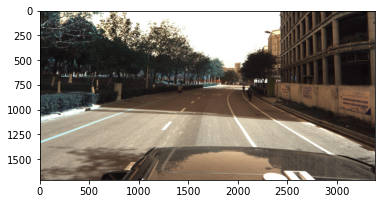

In [81]:
#从lmdb文件中恢复出图片信息
import cv2
import lmdb
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def get_image(lmdb_data_dir):
    env=lmdb.open(lmdb_data_dir)
    with env.begin(write=False) as txn:
    # 获取图像数据
        image_bin = txn.get(('image_'+lmdb_data_dir[-1]).encode())#找出对应的key
        label_bin = txn.get(('label_'+lmdb_data_dir[-1]).encode()) 

        # 将二进制文件转为十进制文件（一维数组）
        image_buf = np.frombuffer(image_bin, dtype=np.uint8)
        label_buf=np.frombuffer(label_bin, dtype=np.uint8)
        # 将数据转换(解码)成图像格式
        # cv2.IMREAD_GRAYSCALE为灰度图，cv2.IMREAD_COLOR为彩色图
        img = cv2.imdecode(image_buf, cv2.IMREAD_COLOR)
        label=cv2.imdecode(image_buf, cv2.IMREAD_GRAYSCALE)
        print("image_shape:",img.shape)
        print("label_shape",label.shape)
    return img,label

lmdb_data_dir="D:\kkb\cartrace\LMDB\data0"
a,b=get_image(lmdb_data_dir)
plt.imshow(a)
plt.show


## 在image_processing.py中用LMDB格式读取

In [ ]:
import os
import cv2
import random
import torch
import numpy as np
from torch.utils.data import Dataset
from imgaug import augmenters as iaa
from utils.process_labels import encode_labels, decode_labels, decode_color_labels


sometimes = lambda aug: iaa.Sometimes(0.5, aug)


# crop the image to discard useless parts
def crop_resize_data(image, label=None, image_size=(1024, 384), offset=690):
    """
    Attention:
    h,w,c = image.shape
    cv2.resize(image,(w,h))
    """
    roi_image = image[offset:, :]
    if label is not None:
        roi_label = label[offset:, :]
        train_image = cv2.resize(roi_image, image_size, interpolation=cv2.INTER_LINEAR)
        train_label = cv2.resize(roi_label, image_size, interpolation=cv2.INTER_NEAREST)
        return train_image, train_label
    else:
        train_image = cv2.resize(roi_image, image_size, interpolation=cv2.INTER_LINEAR)
        return train_image

class LaneDatasetHomework(Dataset):

    def __init__(self, lmdb_file, num_samples, transform=None):
        super(LaneDatasetHomework, self).__init__()
        self.env = lmdb.open(lmdb_file)
        self.txn = self.env.begin()
        self.nSamples = int(self.txn.get('num-samples'))  # num-samples¥Ê¥¢µƒ «LMDB÷–Õº∆¨µƒµƒ∏ˆ ˝
        self.nSamples = min(self.nSamples, num_samples)
        self.transform = transform

    def __len__(self):
        return self.nSamples

    def __getitem__(self, idx):
        idx += 1
        imageKey = 'image-%09d' % idx  # Key
        labelKey = 'label-%09d' % idx
        imageBin = self.txn.get(imageKey.encode())  # ªÒ»°ÕºœÒ ˝æ›
        labelBin = self.txn.get(labelKey.encode())
        # Ω´∂˛Ω¯÷∆Œƒº˛◊™Œ™ ÆΩ¯÷∆Œƒº˛
        imageBuf = np.frombuffer(imageBin, dtype=np.unit8)
        labelBuf = np.frombuffer(labelBin, dtype=np.unit8)
        
        # cv2.IMREAD_GRAYSCALE为灰度图，cv2.IMREAD_COLOR为彩色图
        img = cv2.imdecode(image_buf, cv2.IMREAD_COLOR)
        label=cv2.imdecode(image_buf, cv2.IMREAD_GRAYSCALE)

        train_img, train_mask = crop_resize_data(img, label)
        train_mask = encode_labels(train_mask)
        sample = [train_img.copy(), train_mask.copy()]
        if self.transform:
            sample = self.transform(sample)
        return sample


##################################################################################
class LaneDataset(Dataset):

    def __init__(self, lmdb_dir, transform=None):#lmdb_dir为存储所有lmdb文件的总路径
        super(LaneDataset, self).__init__()
        
        child_dirs=os.listdir(lmdb_dir)#返回子文件夹名称
        
        for child_dir in child_dirs:
            lmdb_data_dir=lmdb_dir+ child_dir    #每对样本LMDB格式的文件路径
            img,label=get_image(lmdb_data_dir)  #读取出一对样本的图片形式
            
            train_img, train_mask = crop_resize_data(img,label)
            
            sample = [train_img.copy(), train_mask.copy()]
            
        return sample
################################################################################   

# pixel augmentation
class ImageAug(object):
    def __call__(self, sample):
        image, mask = sample
        if np.random.uniform(0,1) > 0.5:
            seq = iaa.Sequential([iaa.OneOf([
                iaa.AdditiveGaussianNoise(scale=(0, 0.2 * 255)),
                iaa.Sharpen(alpha=(0.1, 0.3), lightness=(0.7, 1.3)),
                iaa.GaussianBlur(sigma=(0, 1.0))])])
            image = seq.augment_image(image)
        return image, mask


# deformation augmentation
class DeformAug(object):
    def __call__(self, sample):
        image, mask = sample
        seq = iaa.Sequential([iaa.CropAndPad(percent=(-0.05, 0.1))])
        seg_to = seq.to_deterministic()
        image = seg_to.augment_image(image)
        mask = seg_to.augment_image(mask)
        return image, mask


class ScaleAug(object):
    def __call__(self, sample):
        image, mask = sample
        scale = random.uniform(0.7, 1.5)
        h, w, _ = image.shape
        aug_image = image.copy()
        aug_mask = mask.copy()
        aug_image = cv2.resize(aug_image, (int (scale * w), int (scale * h)))
        aug_mask = cv2.resize(aug_mask, (int (scale * w), int (scale * h)))
        if (scale < 1.0):
            new_h, new_w, _ = aug_image.shape
            pre_h_pad = int((h - new_h) / 2)
            pre_w_pad = int((w - new_w) / 2)
            pad_list = [[pre_h_pad, h - new_h - pre_h_pad], [pre_w_pad, w - new_w - pre_w_pad], [0, 0]]
            aug_image = np.pad(aug_image, pad_list, mode="constant")
            aug_mask = np.pad(aug_mask, pad_list[:2], mode="constant")
        if (scale > 1.0):
            new_h, new_w, _ = aug_image.shape
            pre_h_crop = int ((new_h - h) / 2)
            pre_w_crop = int ((new_w - w) / 2)
            post_h_crop = h + pre_h_crop
            post_w_crop = w + pre_w_crop
            aug_image = aug_image[pre_h_crop:post_h_crop, pre_w_crop:post_w_crop]
            aug_mask = aug_mask[pre_h_crop:post_h_crop, pre_w_crop:post_w_crop]
        return aug_image, aug_mask


class CutOut(object):
    def __init__(self, mask_size, p):
        self.mask_size = mask_size
        self.p = p

    def __call__(self, sample):
        image, mask = sample
        mask_size_half = self.mask_size // 2
        offset = 1 if self.mask_size % 2 == 0 else 0

        h, w = image.shape[:2]
        cxmin, cxmax = mask_size_half, w + offset - mask_size_half
        cymin, cymax = mask_size_half, h + offset - mask_size_half
        cx = np.random.randint(cxmin, cxmax)
        cy = np.random.randint(cymin, cymax)
        xmin, ymin = cx - mask_size_half, cy - mask_size_half
        xmax, ymax = xmin + self.mask_size, ymin + self.mask_size
        xmin, ymin, xmax, ymax = max(0, xmin), max(0, ymin), min(w, xmax), min(h, ymax)
        if np.random.uniform(0, 1) < self.p:
            image[ymin:ymax, xmin:xmax] = (0, 0, 0)
        return image, mask


class ToTensor(object):
    def __call__(self, sample):

        image, mask = sample
        image = np.transpose(image,(2,0,1))
        image = image.astype(np.float32)
        mask = mask.astype(np.long)
        return {'image': torch.from_numpy(image.copy()),
                'mask': torch.from_numpy(mask.copy())}


def expand_resize_data(prediction=None, submission_size=(3384, 1710), offset=690):
    pred_mask = decode_labels(prediction)
    expand_mask = cv2.resize(pred_mask, (submission_size[0], submission_size[1] - offset), interpolation=cv2.INTER_NEAREST)
    submission_mask = np.zeros((submission_size[1], submission_size[0]), dtype='uint8')
    submission_mask[offset:, :] = expand_mask
    return submission_mask


def expand_resize_color_data(prediction=None, submission_size=(3384, 1710), offset=690):
    color_pred_mask = decode_color_labels(prediction)
    color_pred_mask = np.transpose(color_pred_mask, (1, 2, 0))
    color_expand_mask = cv2.resize(color_pred_mask, (submission_size[0], submission_size[1] - offset), interpolation=cv2.INTER_NEAREST)
    color_submission_mask = np.zeros((submission_size[1], submission_size[0], 3), dtype='uint8')
    color_submission_mask[offset:, :, :] = color_expand_mask
    return color_submission_mask
